In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
def process_dates(df):
    df = df.copy()
    df["ApplicationDate"] = pd.to_datetime(df["ApplicationDate"])
    df["app_year"] = df["ApplicationDate"].dt.year
    df["app_month"] = df["ApplicationDate"].dt.month
    df["app_dayofweek"] = df["ApplicationDate"].dt.dayofweek
    return df.drop(columns=["ApplicationDate"])

In [43]:
TARGET = "LoanApproved"

train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train_c.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test_c.csv")

train = process_dates(train)
test = process_dates(test)

print(train.shape)

train = train.dropna(subset=[TARGET])

print(train.shape)
train.head()


(11017, 37)
(10487, 37)


,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,...,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,app_year,app_month,app_dayofweek
0,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,0.151985,...,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,2010.0,6.0,5.0
1,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,0.175693,...,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,1996.0,9.0,0.0
2,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,0.444605,...,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,2015.0,1.0,0.0
3,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,0.188452,...,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,1981.0,5.0,1.0
4,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,0.273431,...,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,1995.0,5.0,6.0


In [44]:
X = train.drop(columns=[TARGET])
y = train[TARGET]

X.shape, y.shape

((10487, 36), (10487,))

### Поглядим

+- сбалансированные классы

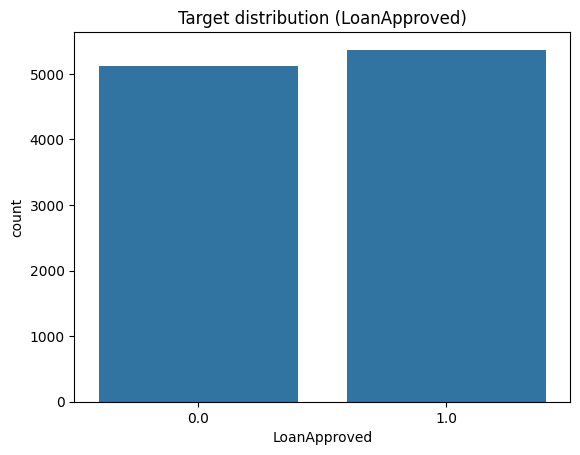

In [45]:
sns.countplot(x=y)
plt.title("Target distribution (LoanApproved)")
plt.show()

- Лучшие фичи – Annual/Monthly Income, CreditScore
- Отрицательно влияют высокие параметры кредита (процентная ставка, отношение долга к доходу)

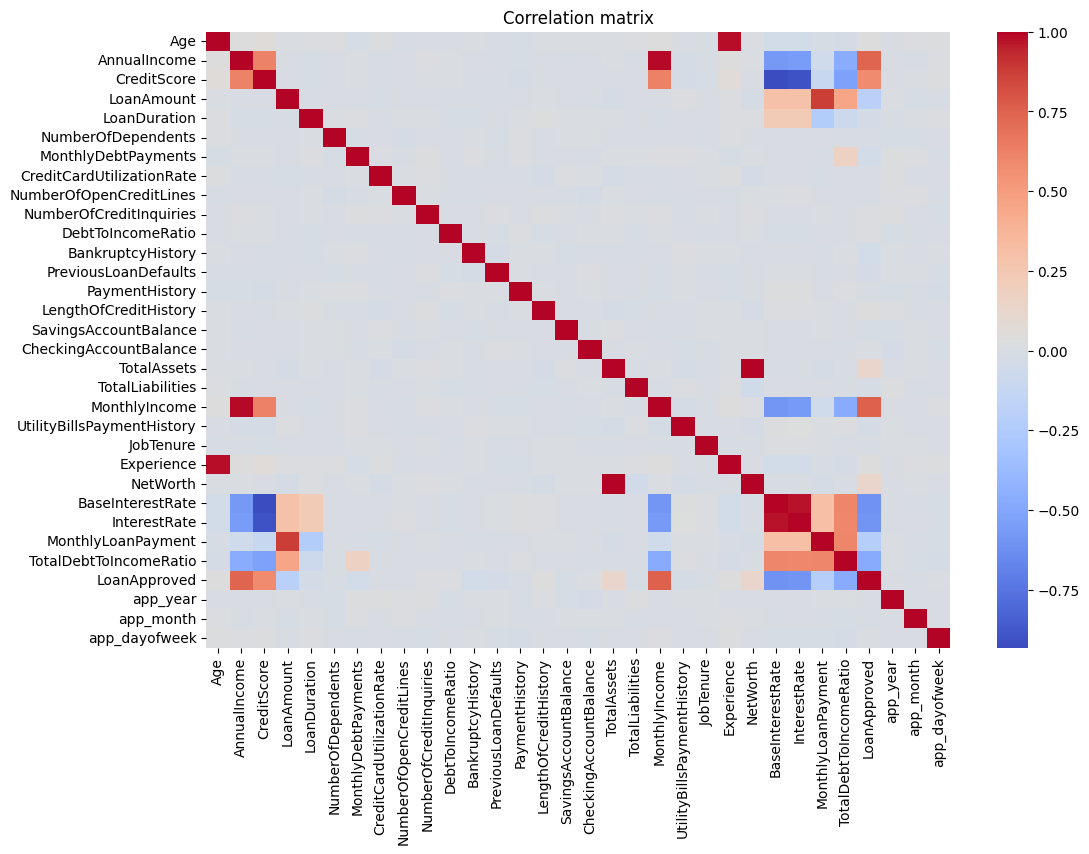

In [46]:
plt.figure(figsize=(12, 8))
sns.heatmap(train.select_dtypes(include=np.number).corr(), cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

### Препроцессинг

In [47]:
from sklearn.impute import SimpleImputer

num_features = X.select_dtypes(include=np.number).columns
cat_features = X.select_dtypes(exclude=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline([
                ("imputer", SimpleImputer(strategy="median")), # вместо nan медиана
                ("scaler", StandardScaler())
            ]),
            num_features
        ),
        (
            "cat",
            Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")), # вместо nan самое частое значение
                ("ohe", OneHotEncoder(handle_unknown="ignore"))
            ]),
            cat_features
        )
    ]
)


In [48]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Бейзлайн – логрег

In [49]:
baseline = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

baseline.fit(X_train, y_train)

y_pred_proba = baseline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

np.float64(0.981929047369646)

Получился очень большой ROC-AUC. Я подумал что это переобученность/утечка, поэтому решил построить фича импортанс по бейзлайну

In [52]:
# посчитаем фича импортанс (в нашем случае коэфициенты в регрессии)

prep = baseline.named_steps["prep"]
clf  = baseline.named_steps["clf"]

feature_names = prep.get_feature_names_out()

coef = clf.coef_[0]

importance = pd.DataFrame({
    "feature": feature_names,
    "coef": coef,
    "abs_coef": np.abs(coef)
}).sort_values("abs_coef", ascending=False)

importance.head(15)

,feature,coef,abs_coef
27,num__TotalDebtToIncomeRatio,-4.661846,4.661846
19,num__MonthlyIncome,2.769551,2.769551
23,num__NetWorth,2.738943,2.738943
25,num__InterestRate,-2.210793,2.210793
1,num__AnnualIncome,1.159717,1.159717
3,num__LoanAmount,-1.138351,1.138351
49,cat__EducationLevel_Doctorate,0.960171,0.960171
50,cat__EducationLevel_High School,-0.689615,0.689615
24,num__BaseInterestRate,0.680278,0.680278
2,num__CreditScore,-0.622880,0.622880


Но вроде как утечки нет. Видимо такой датасет

### BaggingClassifier

In [53]:
from sklearn.base import clone


class MyBaggingClassifier:
    def __init__(self, base_model, n_estimators=10):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.models = []

    def fit(self, X, y):
        self.models = []
        n = len(X)

        for _ in range(self.n_estimators):
            idx = np.random.choice(n, n, replace=True)
            model = clone(self.base_model)
            model.fit(X.iloc[idx], y.iloc[idx])
            self.models.append(model)

    def predict_proba(self, X):
        probs = np.array([m.predict_proba(X)[:, 1] for m in self.models])
        return probs.mean(axis=0)


In [54]:
base_model = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(max_depth=5))
])

my_bag = MyBaggingClassifier(
    base_model=base_model,
    n_estimators=20
)

my_bag.fit(X_train, y_train)

my_val_proba = my_bag.predict_proba(X_val)

roc_auc_score(y_val, my_val_proba)

np.float64(0.9751190242376631)

In [55]:
sk_bag = Pipeline([
    ("prep", preprocessor),
    ("clf", BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=5),
        n_estimators=20,
        random_state=42
    ))
])

sk_bag.fit(X_train, y_train)
roc_auc_score(y_val, sk_bag.predict_proba(X_val)[:, 1])

np.float64(0.9741224576641062)

+- одинаковый результат с моей реализацией

### Бустинги

In [56]:
class MyGradientBoosting:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.lr = learning_rate
        self.max_depth = max_depth
        self.models = []

    def fit(self, X, y):
        self.models = []
        pred = np.zeros(len(y))

        for _ in range(self.n_estimators):
            residual = y - pred
            model = DecisionTreeClassifier(max_depth=self.max_depth)
            model.fit(X, residual > 0)
            self.models.append(model)
            pred += self.lr * model.predict(X)

    def predict_proba(self, X):
        pred = np.zeros(len(X))
        for model in self.models:
            pred += self.lr * model.predict(X)
        return 1 / (1 + np.exp(-pred))


In [58]:
my_gb = Pipeline([
    ("prep", preprocessor),
    ("clf", MyGradientBoosting(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3
    ))
])

my_gb.fit(X_train, y_train)
roc_auc_score(y_val, my_gb.predict_proba(X_val))

np.float64(0.8901012569832403)

In [59]:
gb = Pipeline([
    ("prep", preprocessor),
    ("clf", GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3
    ))
])

gb.fit(X_train, y_train)

roc_auc_score(y_val, gb.predict_proba(X_val)[:, 1])

np.float64(0.980860647986499)

Градиентский бустинг из sklearn сильно лучше

In [64]:
!pip install optuna catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.1 MB/s eta 0:00:00


In [65]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


models = {
    "LightGBM": LGBMClassifier(n_estimators=300, verbosity=-1),
    "XGBoost": XGBClassifier(n_estimators=300, eval_metric="logloss"),
    "CatBoost": CatBoostClassifier(verbose=0)
}


for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", model)
    ])
    pipe.fit(X_train, y_train)
    auc = roc_auc_score(y_val, pipe.predict_proba(X_val)[:, 1])
    print(name, auc)


[LightGBM] [Info] Number of positive: 4293, number of negative: 4096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4664
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511742 -> initscore=0.046975
[LightGBM] [Info] Start training from score 0.046975
LightGBM 0.9832111266294228
XGBoost 0.9823918688896647
CatBoost 0.9829610757099628


+- сравнимый результат у sklearn, LightGBM, XGBoost и CatBoost. Лучше чем у меня 😬

In [67]:
import optuna

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "random_state": 42,
        "verbosity": -1
    }

    model = LGBMClassifier(**params)
    pipe = Pipeline([("prep", preprocessor), ("clf", model)])

    score = cross_val_score(pipe, X, y, cv=3, scoring="roc_auc").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

study.best_params


[I 2025-12-14 18:33:54,055] A new study created in memory with name: no-name-e732b6f2-6052-49b5-9391-3b6aebfdfccb
[I 2025-12-14 18:33:56,656] Trial 0 finished with value: 0.983743367038468 and parameters: {'n_estimators': 295, 'learning_rate': 0.13186079823099303, 'max_depth': 4}. Best is trial 0 with value: 0.983743367038468.
[I 2025-12-14 18:34:02,926] Trial 1 finished with value: 0.9840570728275356 and parameters: {'n_estimators': 361, 'learning_rate': 0.05530274692086382, 'max_depth': 8}. Best is trial 1 with value: 0.9840570728275356.
[I 2025-12-14 18:34:04,584] Trial 2 finished with value: 0.9834992546694229 and parameters: {'n_estimators': 284, 'learning_rate': 0.137021198235847, 'max_depth': 3}. Best is trial 1 with value: 0.9840570728275356.
[I 2025-12-14 18:34:06,971] Trial 3 finished with value: 0.983652069614129 and parameters: {'n_estimators': 315, 'learning_rate': 0.14518922384518046, 'max_depth': 4}. Best is trial 1 with value: 0.9840570728275356.
[I 2025-12-14 18:34:09,

{'n_estimators': 396, 'learning_rate': 0.044482318630232616, 'max_depth': 8}

In [68]:
best_lgbm = LGBMClassifier(
    **study.best_params,
    random_state=42,
    verbose=-1
)

lgbm_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", best_lgbm)
])

lgbm_pipe.fit(X_train, y_train)

roc_auc_score(y_val, lgbm_pipe.predict_proba(X_val)[:, 1])


np.float64(0.9826810186801677)

### Метрики

In [80]:
def my_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def my_precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp)

def my_recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn)

def my_f1(y_true, y_pred):
    p = my_precision(y_true, y_pred)
    r = my_recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0

def my_roc_auc(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    pos_scores = y_pred[y_true == 1]
    neg_scores = y_pred[y_true == 0]

    count = 0
    for ps in pos_scores:
        count += np.sum(ps > neg_scores)
        count += 0.5 * np.sum(ps == neg_scores)

    return count / (len(pos_scores) * len(neg_scores))

def my_pr_auc(y_true, y_score):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    # сортируем по score по убыванию
    order = np.argsort(-y_score)
    y_true = y_true[order]

    tp = 0
    fp = 0

    precisions = []
    recalls = []

    total_positives = np.sum(y_true == 1)

    for i in range(len(y_true)):
        if y_true[i] == 1:
            tp += 1
        else:
            fp += 1

        precision = tp / (tp + fp)
        recall = tp / total_positives if total_positives > 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    precisions = np.array(precisions)
    recalls = np.array(recalls)

    ap = 0.0
    prev_recall = 0.0

    for p, r in zip(precisions, recalls):
        ap += p * (r - prev_recall)
        prev_recall = r

    return ap


In [81]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

# вероятности и бинарные предсказания
y_val_proba = lgbm_pipe.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba >= 0.5).astype(int)

print("Accuracy:", my_accuracy(y_val, y_val_pred), accuracy_score(y_val, y_val_pred))
print("Precision:", my_precision(y_val, y_val_pred), precision_score(y_val, y_val_pred))
print("Recall:", my_recall(y_val, y_val_pred), recall_score(y_val, y_val_pred))
print("F1:", my_f1(y_val, y_val_pred), f1_score(y_val, y_val_pred, average="binary"))

print("ROC-AUC:", my_roc_auc(y_val, y_val_proba), roc_auc_score(y_val, y_val_proba))
print("PR-AUC:", my_pr_auc(y_val, y_val_proba), average_precision_score(y_val, y_val_proba))

Accuracy: 0.9280266920877026 0.9280266920877026
Precision: 0.9301025163094129 0.9301025163094129
Recall: 0.9292364990689013 0.9292364990689013
F1: 0.9296693060083838 0.9296693060083838
ROC-AUC: 0.9826810186801676 0.9826810186801677
PR-AUC: 0.9843504437464579 0.9843505757159134


Метрики совпадают

In [89]:
final_model = lgbm_pipe

test_proba = final_model.predict_proba(test.drop(columns=["ID"]))[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

In [92]:
submission = pd.DataFrame({
    "ID": test["ID"],
    "LoanApproved": test_pred
})

print(submission.shape)
print(submission.isna().sum())

submission.head()


(5000, 2)
ID              0
LoanApproved    0
dtype: int64


,ID,LoanApproved
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1


In [94]:
submission.to_csv("submission.csv", index=False)